# Predicting Yelp Star Ratings
In this little exercise, I am going to have a look at the distribution of Yelp ratings (1 to 5 stars) and their correlations to business and user attributes. Eventually I am attempting to use some ML algorithms to predict a rating from business / user attributes and basic properties of the review test.

### Import statements

In [1]:
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
import random
import re

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
#matplotlib.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
def format_column_names(dataFrame):
    dataFrame.columns = dataFrame.columns.str.replace('[^\w.]+','_')
    dataFrame.columns = dataFrame.columns.str.lower()
    
pd.options.display.max_seq_items = 500

### User Settings

In [3]:
# The fraction (random sample) of the review dataset, which is to be parsed
# (values larges than 0.1 will cause memory overflows when performing in-memory merges)
REVIEW_FRAC = 0.1

# The minimium number of user votes for a review to consider it to be relevant
MIN_VOTES = 5

### Verify the source directory

In [4]:
# Set the source directory for the input csv files (business.csv, user.csv, review.csv)
source_dir = os.path.join( os.getcwd(), 'scratch' )

required_files = ['business.csv', 'user.csv', 'review.csv']

nfiles_found = sum( os.path.isfile( os.path.join(source_dir, f) ) for f in required_files)
if nfiles_found < len(required_files):
    source_dir = input('Specify CSV source directory: ')
if nfiles_found < len(required_files):
    print('Source files not found.')
    sys.exit(1)
    
print('Source directory: {0}'.format(source_dir))

Source directory: /home/marco/workspace-python/YelpExercise/scratch


## Data Wrangling


### Load and format business data

In [5]:
businesses_file = os.path.join(source_dir, 'business.csv')

# Load business data
businesses = pd.read_csv( businesses_file,
    parse_dates=True,
    low_memory=False,
    index_col='business_id'
)
format_column_names(businesses)

# Drop irrelevant columns
irrel_cols = [col for col in list(businesses) if col.startswith('attributes.hair_types')]
businesses.drop(irrel_cols, axis=1, inplace=True)

# Identify column starting with 'attribute'
attr_cols = [col for col in list(businesses) if col.startswith('attributes.')]

# Convert attribute columns to numeric values (no -> yes: -1 -> 1)
businesses[attr_cols] = businesses[attr_cols].replace(
    to_replace=[True, 'yes', 'full_bar', 'free', 'yes_free', 'quiet', 'yes_corkage', 'beer_and_wine'], value=1 )
businesses[attr_cols] = businesses[attr_cols].replace(
    to_replace=[False, 'no', 'none', 'very_loud'], value=-1 )
businesses[attr_cols] = businesses[attr_cols].apply(pd.to_numeric, errors='coerce').fillna(0).apply(pd.to_numeric, errors='coerce', downcast='integer')

# Convert categorical data
businesses['city_num'] = pd.Categorical(businesses['city']).codes

#businesses.columns
#businesses.info()

In [6]:
# Plot the business mean ratings
#star_counts = businesses.stars.value_counts(sort=False, normalize=True).sort_index()
#star_counts.plot(kind="bar", title="Business Mean Ratings", rot='0').set_xlabel('Rating')

### Load and format user data

In [7]:
users_file = os.path.join(source_dir, 'user.csv')

# Load user data
users = pd.read_csv( users_file, parse_dates=True, index_col='user_id' )
format_column_names(users)

compl_cols = [col for col in list(users) if col.startswith('compliments.')]
users['compliments'] = users[compl_cols].sum(axis=1)

vote_cols = [col for col in list(users) if col.startswith('votes.')]
users['votes'] = users[vote_cols].sum(axis=1)

#users.columns
#users.info()

### Load and format reviews data

In [8]:
reviews_file = os.path.join(source_dir, 'review.csv')

# count lines
#num_lines = sum(1 for _ in open(reviews_file))
num_lines = 10000000
# configure random line indices to skip
skip_idx = random.sample(range(1, num_lines), num_lines - int(REVIEW_FRAC*num_lines))

# only load a random fraction of the reviews dataset, specified by REVIEW_FRAC
reviews = pd.read_csv( reviews_file,
    parse_dates=True,
    index_col='review_id',
    skiprows=skip_idx
)
format_column_names(reviews)

reviews['text_length'] = reviews['text'].str.len()
reviews['text_wc'] = reviews['text'].str.split().apply(len)

vote_cols = [col for col in list(reviews) if col.startswith('votes.')]
reviews['votes'] = reviews[vote_cols].sum(axis=1)

times = pd.DatetimeIndex(reviews.date)
reviews['year'] = times.year

#reviews.columns
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268371 entries, jVVv_DA5mCDB6mediuwHAw to 5-pv7M86ZdrXjfHPkPsZug
Data columns (total 13 columns):
business_id     268371 non-null object
date            268371 non-null object
stars           268371 non-null int64
text            268371 non-null object
type            268371 non-null object
user_id         268371 non-null object
votes.cool      268371 non-null int64
votes.funny     268371 non-null int64
votes.useful    268371 non-null int64
text_length     268371 non-null int64
text_wc         268371 non-null int64
votes           268371 non-null int64
year            268371 non-null int32
dtypes: int32(1), int64(7), object(5)
memory usage: 27.6+ MB


### Merge reviews, users and business tables (left joins)

In [9]:
%time rb = pd.merge(reviews, businesses, how='left', left_on='business_id', right_index=True, suffixes=('@reviews', '@businesses'))
%time rbu = pd.merge(rb, users, how='left', left_on='user_id', right_index=True, suffixes=('@reviews', '@users'))

#rbu['stars@reviews'].loc[rbu['votes@reviews'] >= 1].size

del businesses
del users
del reviews

#rbu.columns
rbu.info()

CPU times: user 356 ms, sys: 4 ms, total: 360 ms
Wall time: 561 ms
CPU times: user 580 ms, sys: 4 ms, total: 584 ms
Wall time: 580 ms
<class 'pandas.core.frame.DataFrame'>
Index: 268371 entries, jVVv_DA5mCDB6mediuwHAw to 5-pv7M86ZdrXjfHPkPsZug
Columns: 119 entries, business_id to votes@users
dtypes: bool(1), float64(16), int16(1), int32(1), int64(14), int8(55), object(31)
memory usage: 142.8+ MB


# Exploratory Data Analysis

### Plot number of votes per review

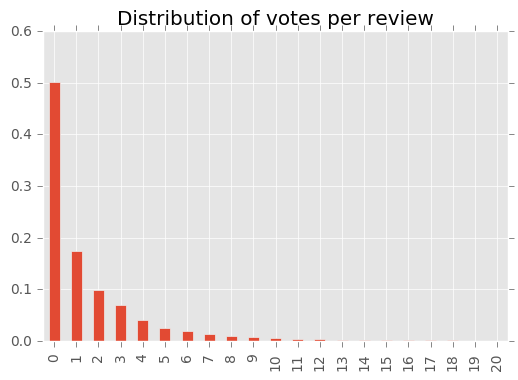

In [10]:
rbu['votes@reviews'].value_counts(normalize=True).ix[:20] \
    .plot.bar(rot=90, title='Distribution of votes per review')

### Investigate the distribution of ratings

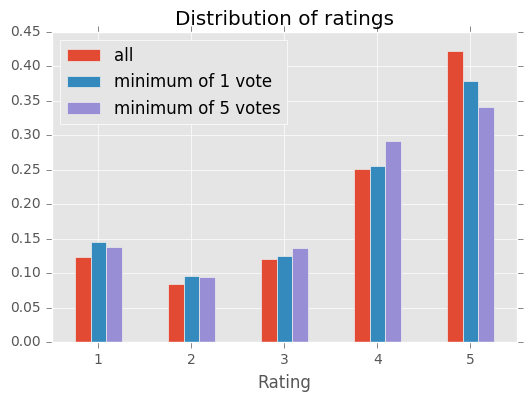

In [11]:
star_counts = rbu['stars@reviews'].value_counts(normalize=True).sort_index()
star_counts_min1 = rbu['stars@reviews'].loc[rbu['votes@reviews'] >= 1].value_counts(normalize=True).sort_index()
#star_counts_min3 = rbu['stars@reviews'].loc[rbu['votes@reviews'] >= 3].value_counts(normalize=True).sort_index()
star_counts_min5 = rbu['stars@reviews'].loc[rbu['votes@reviews'] >= 5].value_counts(normalize=True).sort_index()

star_counts_comb = pd.concat([star_counts, star_counts_min1, star_counts_min5], axis=1)
star_counts_comb.columns = ['all', 'minimum of 1 vote', 'minimum of 5 votes']

star_counts_comb.plot.bar(title="Distribution of ratings", stacked=False, rot=0).set_xlabel('Rating')

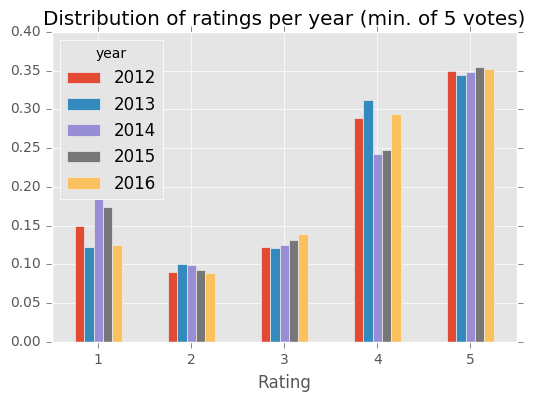

In [12]:
star_counts_per_year = rbu.loc[rbu['votes@reviews'] >= MIN_VOTES].groupby(['year'])['stars@reviews'].value_counts(normalize=True).unstack().transpose()
star_counts_per_year[star_counts_per_year.columns[-5:]].plot.bar(title="Distribution of ratings per year (min. of {0} votes)".format(MIN_VOTES), stacked=False, rot=0).set_xlabel('Rating')

### Investigate correlations with the ratings column

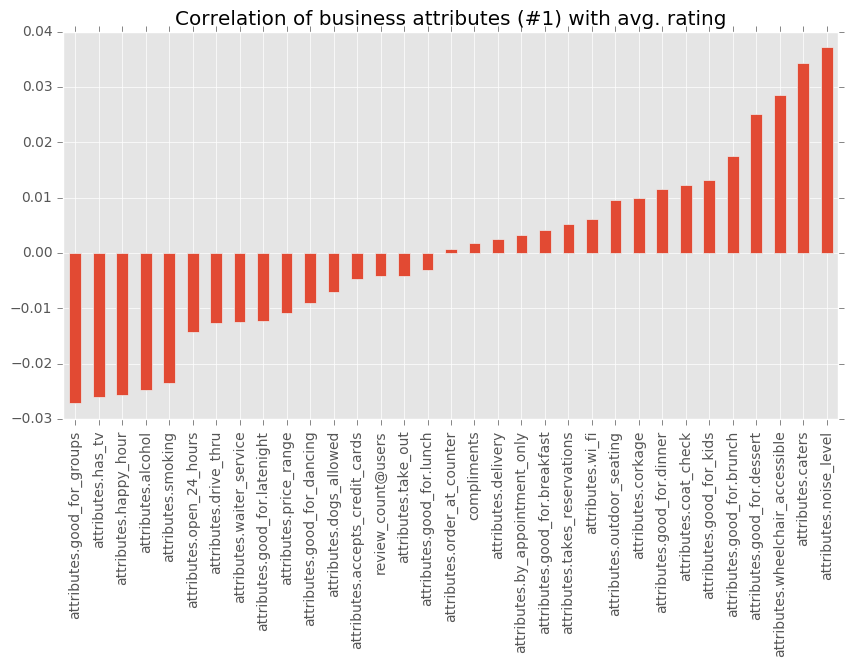

In [13]:
cols = ['attributes.accepts_credit_cards',
 'attributes.alcohol',
 'attributes.by_appointment_only',
 'attributes.caters',
 'attributes.coat_check',
 'attributes.corkage',
 'attributes.delivery',
 'attributes.dogs_allowed',
 'attributes.drive_thru'] \
  + [col for col in list(rbu) if col.startswith('attributes.good_for')] \
  + ['attributes.happy_hour',
 'attributes.has_tv',
 'attributes.noise_level',
 'attributes.open_24_hours',
 'attributes.order_at_counter',
 'attributes.outdoor_seating',
 'attributes.price_range',
 'attributes.smoking',
 'attributes.take_out',
 'attributes.takes_reservations',
 'attributes.waiter_service',
 'attributes.wheelchair_accessible',
 'attributes.wi_fi',
 'review_count@users',
 'compliments']
correls = rbu[cols].corrwith(rbu['stars@reviews'], drop=True).sort_values()
correls.plot.bar(figsize=(10,5), title='Correlation of business attributes (#1) with avg. rating')

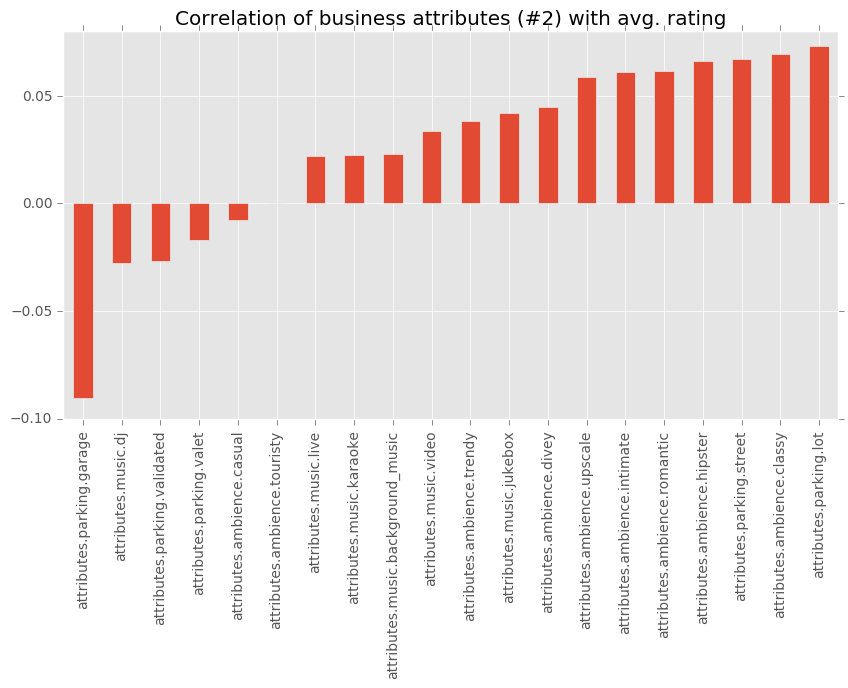

In [14]:
cols = [col for col in list(rbu) if re.search('(\.ambience|\.music|\.parking)', col)]
correls = rbu[cols].corrwith(rbu['stars@businesses'], drop=True).sort_values()
correls.plot.bar(figsize=(10,5), title='Correlation of business attributes (#2) with avg. rating')

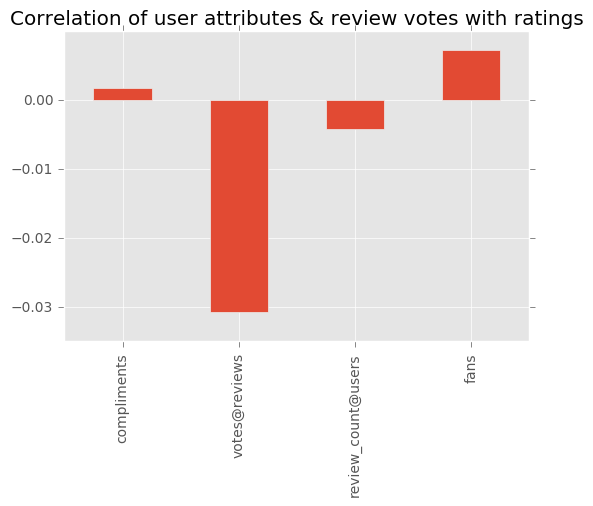

In [15]:
cols = ['compliments', 'votes@reviews', 'review_count@users', 'fans']
correls = rbu[cols].corrwith(rbu['stars@reviews'], drop=True)
correls.plot.bar(title='Correlation of user attributes & review votes with ratings')

In [16]:
# rbu.loc[rbu['votes'] >= 5].groupby(['stars_review'])['text_length'].mean().plot.bar(title="Mean review length (characters) vs. rating (min. of 5 votes)", stacked=False, rot=0).set_xlabel('Rating')

### Investigate the relation between review word count and rating

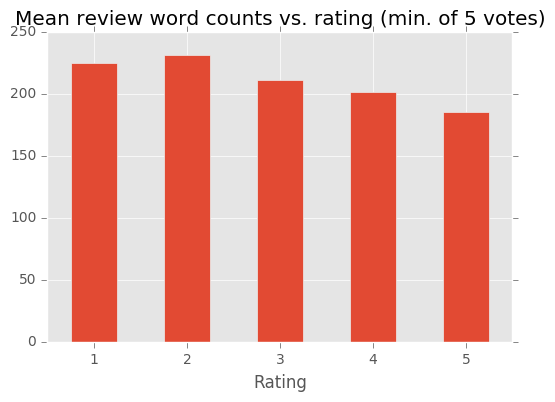

In [17]:
rbu.loc[rbu['votes@reviews'] >= MIN_VOTES].groupby(['stars@reviews'])['text_wc'].mean().plot.bar(title="Mean review word counts vs. rating (min. of 5 votes)", stacked=False, rot=0).set_xlabel('Rating')

In [18]:
rbu.columns

Index(['business_id', 'date', 'stars@reviews', 'text', 'type@reviews',
       'user_id', 'votes.cool@reviews', 'votes.funny@reviews',
       'votes.useful@reviews', 'text_length', 'text_wc', 'votes@reviews',
       'year', 'attributes.accepts_credit_cards',
       'attributes.accepts_insurance', 'attributes.alcohol',
       'attributes.ambience.casual', 'attributes.ambience.classy',
       'attributes.ambience.divey', 'attributes.ambience.hipster',
       'attributes.ambience.intimate', 'attributes.ambience.romantic',
       'attributes.ambience.touristy', 'attributes.ambience.trendy',
       'attributes.ambience.upscale', 'attributes.attire', 'attributes.byob',
       'attributes.byob_corkage', 'attributes.by_appointment_only',
       'attributes.caters', 'attributes.coat_check', 'attributes.corkage',
       'attributes.delivery', 'attributes.dogs_allowed',
       'attributes.drive_thru', 'attributes.good_for_dancing',
       'attributes.good_for_groups', 'attributes.good_for.breakfas

# Predictive Data Analysis
## Predict a rating from business/user attributes and the review text

### Split the available data into training and test set

In [19]:
rbu_min_votes = rbu.loc[rbu['votes@reviews'] >= MIN_VOTES]

In [20]:
data_train, data_test = train_test_split(rbu_min_votes, test_size = 0.2)

attr_cols = [col for col in list(rbu) if re.match('(votes\..+@users|attributes\.|city_num)', col)]
text_col = 'text'
label_col = 'stars@reviews'

### Vectorize the review texts

In [21]:
# train the vectorizer from training data (review texts)
vect = CountVectorizer()
vect.fit(data_train[text_col])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### Prepare features and labels

In [22]:
# collect features
X_train_attr = np.array(data_train[attr_cols])
X_test_attr = np.array(data_test[attr_cols])

X_train_dtm = vect.transform(data_train[text_col])
X_test_dtm = vect.transform(data_test[text_col])

# collect labels
y_train = np.array(data_train[label_col])
y_test = np.array(data_test[label_col])

### Multinomial Naive Bayes

In [23]:
# use a Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred = nb.predict(X_test_dtm)

In [24]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

0.53048479868529175

In [25]:
# calculate the mean error
metrics.mean_absolute_error(y_test, y_pred)

0.6800328677074774

In [26]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[ 633,   74,   42,   47,   27],
       [ 184,   96,  113,  141,   41],
       [  84,   44,  163,  461,   96],
       [  96,   15,   89, 1096,  499],
       [ 141,    6,   19,  638, 1240]])

In [27]:
# data_test[y_test > y_pred]

,business_id,date,stars@reviews,text,type@reviews,user_id,votes.cool@reviews,votes.funny@reviews,votes.useful@reviews,text_length,...,friends,name@users,review_count@users,type,votes.cool@users,votes.funny@users,votes.useful@users,yelping_since,compliments,votes@users
review_id,,,,,,,,,,,,,,,,,,,,,
qO9IZql9WSSWh0t_tdakDA,uJYw4p59AKh8c8h5yWMdOw,2011-11-10,5,We reserved a non smoking KING room through bo...,review,rp82QG3ewXv0XCeXqT2ojA,5,3,7,1100,...,"['rpOyqD_893cqmDAtJLbdog', 'pz97SxRe1Vk-5_K6EB...",Olivia,1064,user,4405,4293,6281,2006-10,3558.0,14979
CXyR2_3LYWos6H6DSX_jTA,DPQeeqUU8Ih9lW8Lh0AD0Q,2010-09-23,2,"Yes, you can get some killer deals if you happ...",review,i8KMQX7nekLSCzb_DVb6yA,3,4,7,1558,...,"['erzVZkeAaVu3DBJ5LPDMqw', 'zTWH9b_ItSdLOK9ype...",Blair,770,user,1517,1057,2351,2007-05,708.0,4925
Bxkp9-n2QaS7BDiZFjTuVw,ES-j5yNTgmgbL4He0h6otA,2008-12-09,5,Top 10 things everyone needs to know about the...,review,uTigTfhQ_kKXkMXMYz7S7g,3,4,6,1083,...,"['7FuLnS_-b79GG-33mwLaMg', 'DrKQzBFAvxhyjLgbPS...",Christopher,451,user,478,428,928,2008-07,235.0,1834
4HH90eli4qLrCRMUoECs-A,EYRqt6hDb2Y9gl0si0NdXA,2012-08-09,5,We had a great time on Southwest Airlines last...,review,kffxYQVQsEpF1DVlQlcGCg,3,1,2,626,...,"['HOleI3jz1MLNUJ6cc1x0Pw', '_yVFOWS2pM6zO3ooQb...",Mario,402,user,1918,1528,2359,2011-09,2142.0,5805
GR6FRc0fzA0OHBCAFvSOmQ,Ht8mXLuqJSTPrU9kvzosUA,2011-08-21,5,I'm speaking for the nightclub... FAVORITE clu...,review,MA8wIal_0td3-6hf7B29dQ,3,2,4,691,...,"['mAuBHENS_DeFCQqrJC_UxA', 'XUssrbu8odaPEuwd-b...",Nina,267,user,203,242,488,2011-08,67.0,933
8eKFyNV_7C9uxa-FUtZ8tw,lIlaoptZjY7DD4pO0Mk8ow,2015-04-22,2,Came here with a friend last night started off...,review,Z13-STol4znuICOHmAi7Dw,1,2,5,1185,...,"['-ANkfLbDf8aiBQ7vywIL6w', 'wyr8JqRyTiqLmapGdj...",Alexa,124,user,223,218,425,2008-09,24.0,866
0vu_Te2Rut22cVRxK1Z3Hw,_v6HIliEOn0l0YaAmBOrxw,2008-06-16,5,"Holy Crap. TI is not the pirate show, gimmicky...",review,25uBXnNZgHDaovC1VTENrQ,3,2,3,934,...,"['lxZSVeJz6KEBW1nlA3JKJg', 'x0j3_eF8LQ40t_eyfP...",Eileen,311,user,950,1032,1147,2007-11,950.0,3129
DQEO89bTpn9tRGphmsXuLw,5rtC3OBCIq0WKVoKH--GCg,2008-09-04,5,I have to admit that I actually did not plan i...,review,iWmEuvrRHqpE7fV-LRxNtw,2,1,3,2693,...,"['pz97SxRe1Vk-5_K6EB9OSA', 'pePGMO6EbDpbaZ7D2m...",Jun,472,user,632,334,918,2006-09,660.0,1884
KUS2d9Y8r_qUNmNAdZUbFg,PBej5DE0QOF-XW0pK1cL5w,2013-10-02,3,This was not the most cheerful place. A few o...,review,tmuVweJdPKDnZGnQOq2L2Q,5,8,7,1106,...,"['zTWH9b_ItSdLOK9ypeFOIw', 'Z78lp4o03tZbGRMwLZ...",Anthony,239,user,1044,752,1355,2008-07,1841.0,3151


### Decision Tree

In [28]:
dtree = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=10)
dtree.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred = dtree.predict(X_test_dtm)

In [29]:
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred)

0.39852095316351682

In [30]:
# calculate the mean error
metrics.mean_absolute_error(y_test, y_pred)

1.0516023007395234

In [31]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)

array([[ 325,   31,   31,  143,  293],
       [ 134,   15,   18,  228,  180],
       [ 103,   13,   17,  415,  300],
       [ 111,   15,   17,  791,  861],
       [  92,    6,   27,  642, 1277]])

In [ ]:
# gb = GradientBoostingClassifier(max_depth=5, n_estimators=1000)
# rf = RandomForestClassifier(n_estimators=1000, criterion='entropy', n_jobs=4, max_depth=10)